In [1]:
import pandas as pd
import nltk
import gensim
from collections import Counter, defaultdict
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from typing import List, Dict, Set
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
types = pd.read_csv('data/types.csv')
types.set_index('Type', inplace=True)

In [3]:
types.head(1)

,Introduction,Strengths and Weaknesses,Romantic Relationships,Friendships,Parenthood,Career Paths,Workplace Habits,Conclusion,Celebrities,Description,Nickname,Definition,E,I,N,S,T,F,J,P
Type,,,,,,,,,,,,,,,,,,,,
INTJ,Introduction\n\nWHO IS AN ARCHITECT (INTJ)?\n\...,Strengths & Weaknesses\nArchitect (INTJ) Stren...,Romantic Relationships\n\n“Of all forms of cau...,Friendships\n\n“A friend to all is a friend to...,Parenthood\n\n“Children must be taught how to ...,Career Paths\n\n“One never notices what has be...,Workplace Habits\n\nWhat Architects (INTJs) wa...,Conclusion\n\n“No escape from patterns and sys...,"['Friedrich Nietzsche', 'Michelle Obama', 'Elo...","Imaginative and strategic thinkers, with a pla...",Architect,An Architect (INTJ) is a person with the Intro...,0,1,1,0,1,0,1,0


In [4]:
types.columns

Index(['Introduction', 'Strengths and Weaknesses', 'Romantic Relationships',
       'Friendships', 'Parenthood', 'Career Paths', 'Workplace Habits',
       'Conclusion', 'Celebrities', 'Description', 'Nickname', 'Definition',
       'E', 'I', 'N', 'S', 'T', 'F', 'J', 'P'],
      dtype='object')

In [5]:
def get_types_descriptions(types) -> Dict[str, str]: 
    """Get a full text that describes each type """

    types_descriptions = {}

    for index, row in types.iterrows():
        types_descriptions[index] = row['Description'] \
            + row['Introduction'] \
            + row['Strengths and Weaknesses'] \
            + row['Romantic Relationships'] \
            + row['Friendships'] \
            + row['Parenthood'] \
            + row['Career Paths'] \
            + row['Workplace Habits'] \
            + row['Conclusion']
        
    return types_descriptions

# generate a single description for each type
df_types = pd.DataFrame()
df_types['FullText'] = pd.Series(get_types_descriptions(types))
df_types.head(1)

,FullText
INTJ,"Imaginative and strategic thinkers, with a pla..."


In [6]:
def preprocessing(
        text: str, lemmatizer: nltk.stem.WordNetLemmatizer, 
        n: int, other_stopwords: List[str] = []) -> List[str]:
    """
    Preprocess text for one document. 

    Applied operations are: to lower case, tokenization, 
    stop words and punctuation removal, 
    lemmatization, n-grams generation
    """
    
    # to lower case and tokenization
    tokens = nltk.word_tokenize(text.lower())

    # stop words and punctuation removal
    tokens = [
        token for token in tokens \
        if token.isalpha() and \
        (token not in nltk.corpus.stopwords.words('english')) and \
        (token not in other_stopwords)
        ]

    # lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if n <= 1:
        return tokens
    
    # n-grams generation
    generated_ngrams = []

    for i in range(1, n + 1):
        processed_text = nltk.utils.ngrams(tokens, i)
        generated_ngrams += [' '.join(grams) for grams in processed_text]

    return generated_ngrams

# generate lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

# types names are stopwords
other_stopwords = [w.lower() for w in list(types.Nickname) + list(types.index)]


In [7]:
df_types["Tokens"] = df_types["FullText"].apply(
    lambda x: preprocessing(x, lemmatizer, 1, other_stopwords=other_stopwords))

df_types.head(1)

,FullText,Tokens
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, person..."


In [8]:
def build_freq_dict(tokens: List[str]) -> defaultdict: 
    """Build a (frequency) dictionary from a list of tokens"""

    default_dict = defaultdict(lambda: 0)
    
    for token in tokens:
        default_dict[token] += 1

    return default_dict

# build frequency dictionaries for each type
df_types["FreqDict"] = df_types["Tokens"].apply(build_freq_dict)
df_types.head(1)

,FullText,Tokens,FreqDict
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, person...","{'imaginative': 2, 'strategic': 2, 'thinker': ..."


## Summarization on MBTI types descriptions 

In [9]:
def sentence_extraction(text: str) -> List[str]:
    """Extract sentences from a text"""

    sentences = nltk.sent_tokenize(text)
    return sentences

# extract sentences from each type description
df_types["Sentences"] = df_types["FullText"].apply(sentence_extraction)
df_types.head(1)

,FullText,Tokens,FreqDict,Sentences
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, person...","{'imaginative': 2, 'strategic': 2, 'thinker': ...","[Imaginative and strategic thinkers, with a pl..."


### Method 1: simple sentence score with word frequency

In [10]:
def simple_sentence_scorer(
        sentence: str, dictionary: defaultdict, 
        lemmatizer: nltk.stem.WordNetLemmatizer, 
        n: int = 1, length_normalize: bool = True) -> float:
    """Score a sentence based on the frequency of its words"""

    preprocessed_sentence = preprocessing(sentence, lemmatizer, n)

    if len(preprocessed_sentence) == 0:
        return 0

    score = 0 
    score += sum([dictionary[token] for token in preprocessed_sentence])

    if length_normalize:
        score /= len(preprocessed_sentence)

    return score

# score each sentence for each type

df_types["SentencesScores"] = df_types.apply(
    lambda row: [
    simple_sentence_scorer(s, row["FreqDict"], lemmatizer) 
        for s in row["Sentences"]
    ], axis=1)
df_types.head(1)

,FullText,Tokens,FreqDict,Sentences,SentencesScores
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, person...","{'imaginative': 2, 'strategic': 2, 'thinker': ...","[Imaginative and strategic thinkers, with a pl...","[19.5, 20.11111111111111, 4.4, 5.3333333333333..."


In [11]:
def select_sentences_by_treshold(scores: List[int], alpha: float) -> List[int]: 
    """Select sentences with a score higher than alpha * avg(scores). 
    It return selected sentences indexes
    """
    avg = sum(scores) / len(scores)
    return [i for i, s in enumerate(scores) if s >= alpha * avg]

def select_top_k_sentences(scores: List[int], k: int) -> List[int]: 
    """Select top k sentences. It return selected sentences indexes"""

    return sorted(range(len(scores)), key=lambda i: scores[i])[-k:]

# make summaries for each type using the first method

alpha = 1.7
k = 20

df_types["Summaries1"] = df_types.apply(
    lambda row: [
        row["Sentences"][i]
        for i in select_sentences_by_treshold(row["SentencesScores"], alpha)
    ], axis=1)

df_types["Summaries2"] = df_types.apply(
    lambda row: [
        row["Sentences"][i]
        for i in select_top_k_sentences(row["SentencesScores"], k)
    ], axis=1)

df_types.head(1)


,FullText,Tokens,FreqDict,Sentences,SentencesScores,Summaries1,Summaries2
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, person...","{'imaginative': 2, 'strategic': 2, 'thinker': ...","[Imaginative and strategic thinkers, with a pl...","[19.5, 20.11111111111111, 4.4, 5.3333333333333...",[As one of the rarest personality types – and ...,"[Dismissive of Emotions – For Architects, rati..."


### Method 2: sentence score with TF-IDF

In [12]:
def calculate_document_frequencies(documents: List[List[str]]) -> Dict[str, int]:
    """Compute the document frequency for each term in a corpus"""

    terms_document_freq = defaultdict(lambda: 0)

    for doc in documents:
        for term in doc:
            terms_document_freq[term] += 1

    return terms_document_freq

# calcluate document frequencies for all types

document_frequencies = calculate_document_frequencies(list(df_types["Tokens"]))


In [13]:
def make_tf_idf_dictionary(
        term_frequency_dictionary: defaultdict, 
        document_frequency_dictionary: defaultdict) -> defaultdict:
    """Make a dictionary where each term is scored with tf-idf"""

    corpus_len = len(term_frequency_dictionary)
    n_docs = len(document_frequency_dictionary)

    tf_idf_dictionary = defaultdict(lambda: 0)

    for term, term_count in term_frequency_dictionary.items():

        if document_frequency_dictionary[term] == 0:
            continue
        
        tf = term_count/corpus_len
        idf = np.log(n_docs/document_frequency_dictionary[term])

        tf_idf_dictionary[term] = tf * idf

    return tf_idf_dictionary

# make tf-idf dictionaries for each type
df_types["TfIdfDict"] = df_types["FreqDict"].apply(
    lambda d: make_tf_idf_dictionary(d, document_frequencies))
df_types.head(1)

,FullText,Tokens,FreqDict,Sentences,SentencesScores,Summaries1,Summaries2,TfIdfDict
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, person...","{'imaginative': 2, 'strategic': 2, 'thinker': ...","[Imaginative and strategic thinkers, with a pl...","[19.5, 20.11111111111111, 4.4, 5.3333333333333...",[As one of the rarest personality types – and ...,"[Dismissive of Emotions – For Architects, rati...","{'imaginative': 0.01176386470450463, 'strategi..."


In [14]:
# score each sentence for each type using tf-idf

df_types["TfIdfSentencesScores"] = df_types.apply(
    lambda row: [
    simple_sentence_scorer(s, row["TfIdfDict"], lemmatizer)
        for s in row["Sentences"]
    ], axis=1)

df_types.head(1)

,FullText,Tokens,FreqDict,Sentences,SentencesScores,Summaries1,Summaries2,TfIdfDict,TfIdfSentencesScores
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, person...","{'imaginative': 2, 'strategic': 2, 'thinker': ...","[Imaginative and strategic thinkers, with a pl...","[19.5, 20.11111111111111, 4.4, 5.3333333333333...",[As one of the rarest personality types – and ...,"[Dismissive of Emotions – For Architects, rati...","{'imaginative': 0.01176386470450463, 'strategi...","[0.07595696705255923, 0.06540384649204929, 0.0..."


In [15]:
# make summaries for each type using tf-idf

df_types["SummariesTfIdf1"] = df_types.apply(
    lambda row: [
        row["Sentences"][i]
        for i in select_sentences_by_treshold(row["TfIdfSentencesScores"], alpha)
    ], axis=1)

df_types["SummariesTfIdf2"] = df_types.apply(
    lambda row: [
        row["Sentences"][i]
        for i in select_top_k_sentences(row["TfIdfSentencesScores"], k)
    ], axis=1)

df_types.head(1)

,FullText,Tokens,FreqDict,Sentences,SentencesScores,Summaries1,Summaries2,TfIdfDict,TfIdfSentencesScores,SummariesTfIdf1,SummariesTfIdf2
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, person...","{'imaginative': 2, 'strategic': 2, 'thinker': ...","[Imaginative and strategic thinkers, with a pl...","[19.5, 20.11111111111111, 4.4, 5.3333333333333...",[As one of the rarest personality types – and ...,"[Dismissive of Emotions – For Architects, rati...","{'imaginative': 0.01176386470450463, 'strategi...","[0.07595696705255923, 0.06540384649204929, 0.0...",[Finding a Better Way\n\nArchitects question e...,[And if any personality type has high standard...


## Clustering on MBTI types descriptions 

In [16]:
# Join tokens in a text that can be vectorized
df_types["TokenOnlyText"] = df_types["Tokens"].apply(lambda x: " ".join(x))
df_types.head(1)

,FullText,Tokens,FreqDict,Sentences,SentencesScores,Summaries1,Summaries2,TfIdfDict,TfIdfSentencesScores,SummariesTfIdf1,SummariesTfIdf2,TokenOnlyText
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, person...","{'imaginative': 2, 'strategic': 2, 'thinker': ...","[Imaginative and strategic thinkers, with a pl...","[19.5, 20.11111111111111, 4.4, 5.3333333333333...",[As one of the rarest personality types – and ...,"[Dismissive of Emotions – For Architects, rati...","{'imaginative': 0.01176386470450463, 'strategi...","[0.07595696705255923, 0.06540384649204929, 0.0...",[Finding a Better Way\n\nArchitects question e...,[And if any personality type has high standard...,imaginative strategic thinker plan person intr...


In [17]:
from typing import Tuple


def make_clustering(
        df: pd.DataFrame, k: int, n_keywords: int, 
        ngram_range: Tuple[int, int]=(1,1), min_df: int=1, max_df: float=1.0):
    """
    Make clustering of the texts in the dataframe df.

    Parameters:
    - df: dataframe with a column "TokenOnlyText" with the text to cluster
    - k: number of clusters
    - n_keywords: number of keywords to extract for each cluster
    - ngram_range: range of ngrams to use for the vectorization
    - min_df: minimum document frequency for a term to be considered
    - max_df: maximum document frequency for a term to be considered

    Returns:
    a dataframe with a column "Cluster" with the cluster for each text
    
    Prints also a summary of the clusters with the top keywords
    """

    # vectorize the text using tf-idf 
    # filtering by document frequency
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df, max_df=max_df)

    # generate sparse matrix
    X = vectorizer.fit_transform(df["TokenOnlyText"])

    # apply K-means
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X)

    clusters = kmeans.labels_.tolist()

    df_types["Cluster"] = clusters

    df2 = pd.DataFrame(X.todense())
    df2["Cluster"] = clusters
    cluster_values = df2.groupby("Cluster").mean()
    
    # get tf-idf terms 
    terms = vectorizer.get_feature_names_out()
    
    for i,r in cluster_values.iterrows():
        print('\nCluster {}: '.format(i))
        print(df[df["Cluster"] == i].index.values)
        print(','.join([terms[t] for t in np.argsort(r)[-n_keywords:]]))

    return df, X



In [18]:
df_types, X = make_clustering(df_types, 4, 10, ngram_range=(1,1), min_df=4, max_df=10)


Cluster 0: 
['ENTJ' 'ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
standard,stable,community,duty,established,tradition,authority,family,respect,dedication

Cluster 1: 
['INTP' 'ENTP' 'ENFJ' 'ENFP']
theory,conversation,analyst,genuine,idealism,logic,insight,chance,debate,intellectual

Cluster 2: 
['INTJ' 'INFJ' 'INFP']
inner,independence,ideal,idealism,generally,perfect,fortunately,insight,said,employee

Cluster 3: 
['ISTP' 'ISFP' 'ESTP' 'ESFP']
appreciated,hobby,excitement,spontaneity,charming,style,exciting,planning,relaxed,fun


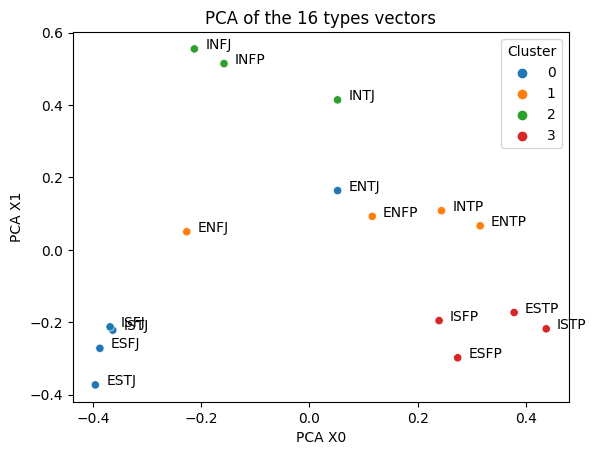

In [19]:
pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X.toarray())

df_types["PCA_X0"] = pca_vecs[:,0]
df_types["PCA_X1"] = pca_vecs[:,1]

sns.scatterplot(data=df_types, x="PCA_X0", y="PCA_X1", hue="Cluster", palette="tab10")

plt.title("PCA of the 16 types vectors")
plt.xlabel("PCA X0")
plt.ylabel("PCA X1")

def label_point(x, y, val, ax):
    a = pd.DataFrame({'x': x, 'y': y, 'val': val})
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df_types["PCA_X0"], df_types["PCA_X1"], df_types.index, plt.gca())

plt.show()



## Topic labeling on MBTI types descriptions

We want to find topics 

In [20]:
types.columns

Index(['Introduction', 'Strengths and Weaknesses', 'Romantic Relationships',
       'Friendships', 'Parenthood', 'Career Paths', 'Workplace Habits',
       'Conclusion', 'Celebrities', 'Description', 'Nickname', 'Definition',
       'E', 'I', 'N', 'S', 'T', 'F', 'J', 'P'],
      dtype='object')

In [21]:
# take as documents all the paragraph of a type
def get_type_paragraphs(df, type_name: str, paragraphs: list = [
        "Introduction", 
        "Strengths and Weaknesses", 
        "Romantic Relationships", 
        "Friendships", 
        "Parenthood", 
        "Career Paths",
        "Workplace Habits",
        "Conclusion", 
        "Description",
    ]) -> List[str]:

    return [df.loc[type_name, :][p] for p in paragraphs]

# get the paragraphs for each type
paragraphs = [p for t in types.index for p in get_type_paragraphs(types, t)]


In [22]:
# extract tokens 
all_tokens = [preprocessing(p, lemmatizer, 1, other_stopwords) for p in paragraphs]

# make a dictionary
all_tokens_dict = gensim.corpora.Dictionary(all_tokens)

# convert tokenized documents into a document-term matrix
corpus = [all_tokens_dict.doc2bow(tokens) for tokens in all_tokens]


In [23]:
# generate LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=all_tokens_dict, passes=20)

for t in lda_model.print_topics(num_words=10):
    print(t)

(0, '0.022*"protagonist" + 0.013*"child" + 0.009*"people" + 0.009*"personality" + 0.007*"parent" + 0.007*"type" + 0.006*"make" + 0.006*"often" + 0.006*"executive" + 0.006*"take"')
(1, '0.021*"need" + 0.012*"personality" + 0.012*"type" + 0.010*"go" + 0.009*"challenge" + 0.009*"many" + 0.009*"learn" + 0.008*"may" + 0.008*"potential" + 0.007*"personal"')
(2, '0.019*"personality" + 0.017*"advocate" + 0.017*"people" + 0.013*"type" + 0.009*"may" + 0.009*"friend" + 0.007*"entrepreneur" + 0.007*"others" + 0.006*"make" + 0.006*"defender"')
(3, '0.018*"personality" + 0.014*"people" + 0.012*"type" + 0.008*"partner" + 0.008*"make" + 0.007*"relationship" + 0.007*"thing" + 0.007*"need" + 0.006*"logistician" + 0.006*"entertainer"')
(4, '0.019*"personality" + 0.015*"child" + 0.013*"type" + 0.012*"people" + 0.010*"architect" + 0.008*"commander" + 0.008*"logician" + 0.007*"executive" + 0.007*"may" + 0.006*"make"')
